In [2]:
import numpy as np
import scipy
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftshift
import librosa as lb

from scipy.signal import hamming, hann, freqz
from matplotlib import pyplot as plt


from audiolazy import lazy_lpc as lpc


In [3]:
plt.ion()



def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analyis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from means are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

------ The computed formants are : [8000. 8000. 8000.]


/tmp/ipykernel_5311/1929300080.py:57: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(filter_transfer_T[:len(filter_transfer_T)//2]), 'r', alpha=0.7)
/tmp/ipykernel_5311/1929300080.py:57: RuntimeWarning: invalid value encountered in multiply
  plt.plot(20*np.log10(filter_transfer_T[:len(filter_transfer_T)//2]), 'r', alpha=0.7)
/home/ara/anaconda3/envs/sound/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


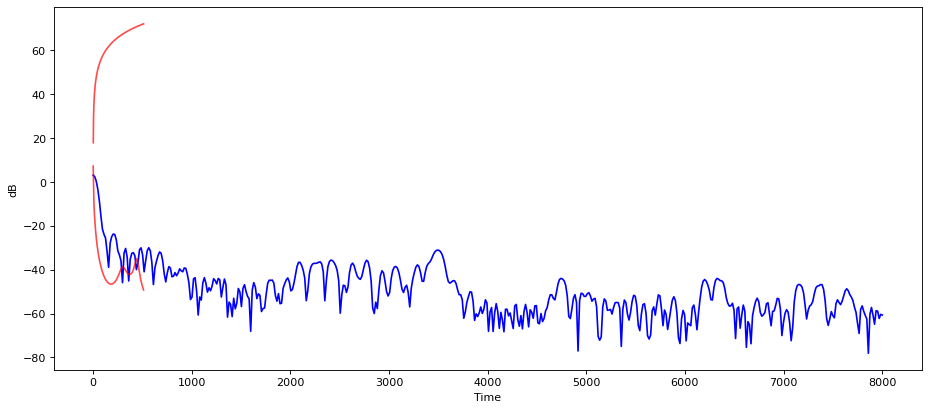

In [50]:

plt.ion()
    
# # read audio
audioIn, fs=lb.load('e.wav', sr=None)   

# filter order
p = 10                    # has to be tuned

# number of DFT points
nfft = 1024

inInd =0
wLen = int(0.02*fs) # 20 ms window
win = hamming(wLen) # hamming window for example

cnt = 0
numframes = np.ceil((len(audioIn)-wLen)/(wLen/2)) # number of franes 
formants  = []                                     # A placeholder for storing formants

# choose a representative frame of the vowel
plot_frame = int(numframes/2)  # middle of the vowel

# The analysis loop
while inInd< len(audioIn)-wLen:
    # audio frame
    frame = audioIn[inInd:inInd+wLen]* win


    # compute LPC and gain 
    filt = lpc.lpc.autocor(frame, p)
    coefficient = filt.numerator
    gain = est_predictor_gain(frame,coefficient,p)

    # Compute the filter transfer function
    filter_transfer = freqz(gain, coefficient, worN=nfft, whole=False, plot=None, fs=fs, include_nyquist=False)
    filter_transfer_real = np.real(filter_transfer)
    filter_transfer_shape = np.asarray(filter_transfer).shape
    filter_transfer_T = np.asarray(filter_transfer).T

    # Compute DFT spectrum
    f = fft(frame,nfft) 

    # Compute roots
    poles = np.roots(coefficient)

    # LPC coefficients are real-valued, the roots occur in complex conjugate pairs. Retain only the roots with +ve sign for the imaginary part 
    poles_img = np.imag(poles)
    poles_img = poles_img[poles_img >= 0]


    # compute formants from roots
    poles_real = np.abs(poles)
    freq = np.linspace(0, fs/2, len(f)//2)
    plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(freq, 20*np.log10(abs(f[:len(f)//2])), 'b')
    plt.plot(20*np.log10(filter_transfer_T[:len(filter_transfer_T)//2]), 'r', alpha=0.7)
    plt.ylabel('dB')
    plt.xlabel('Time')


    # convert to Hertz from angular frequencies
    angz = np.angle(np.imag(poles)/ np.real(poles))
    angz = angz*(fs/(2*np.pi))

    # sort the formants in increasing order
    angz = np.sort(angz)

    # remove zero frequencies
    angz = angz[angz !=0]

    # First three formants
    formants.append(angz[:3]) 

    inInd = inInd + int(wLen/2) # frame advance

    cnt = cnt+1

    # plot the FFT spectrum and LPC spectrum here for chosen frame
    if cnt == plot_frame :
        # plot DFT spectrum (remember both in dB scale)
        freq = np.linspace(0, fs/2, len(f)//2)
        plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(freq, 20*np.log10(abs(f[:len(f)//2])))

        # plot LPC spectrum
        plt.figure()
        

formants = np.array(formants)

print('------ The computed formants are :', np.mean(formants, 0))

# Refine formant estimations (optional)

In [ ]:
# Problem 1.d
# When you increase the order, the program requires more calculation and predict the formants more accurate. 
# Problem 2.a
# When you compute the roots of LP filter you can get the poles. 